In [2]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

import polars as pl

from src.matches import store_matches, scan_matches, generate_matches, generate_millions_matchs
from src.daily_results import generate_dummy_daily_results

In [8]:
data_path = Path('data/logs/matches.log')

lazy_df = scan_matches(data_path)
df = lazy_df.collect()
df.head()

player_id,match_id,operator_id,nb_kills
str,str,u8,u8
"""9e55f54f-a293-4ec5-b7d6-9bab73…","""9ba4bf49-8111-413e-bce6-557d22…",107,3
"""6f560325-2d65-4d21-9f9c-ea8203…","""c029855e-87ff-49c0-95cd-b7ce32…",253,1
"""4377acde-020e-4cf3-a6d7-8a7ab2…","""c51b48a1-b7c7-408e-98fe-219da5…",233,4
"""45d90033-79a4-4dfe-b1d3-14b848…","""758adcc6-ebe3-416b-b0c7-f0bf0c…",72,4
"""179db9c6-9c0d-4dca-aef9-a86f7b…","""84ac25ed-d72f-4011-80f6-46f80f…",84,3


The logs does not look sorted by match_id, player_id or operator_id.

In [9]:
df.shape

(55833, 4)

In [10]:
df.null_count()

player_id,match_id,operator_id,nb_kills
u64,u64,u64,u64
0,0,0,0


In [11]:
operators = df['operator_id']
unique_operators = operators.unique().to_numpy()
np.sort(unique_operators)

array([ 14,  24,  30,  46,  64,  72,  73,  84, 100, 107, 109, 112, 130,
       132, 173, 193, 194, 211, 230, 233, 237, 241, 245, 253], dtype=uint8)

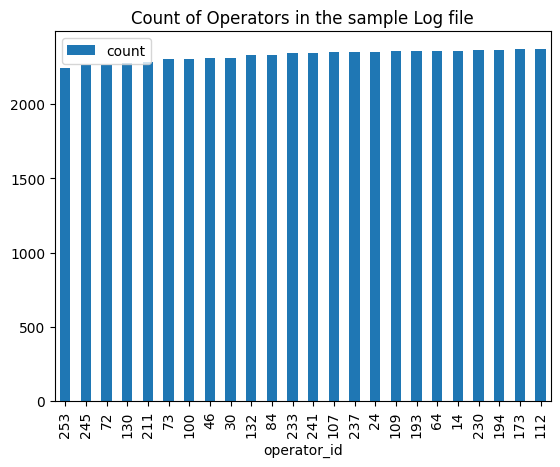

In [12]:
operators_count = operators.value_counts().sort('count')
operators_count.to_pandas().plot(kind='bar', x='operator_id', y='count', title='Count of Operators in the sample Log file')
plt.show()

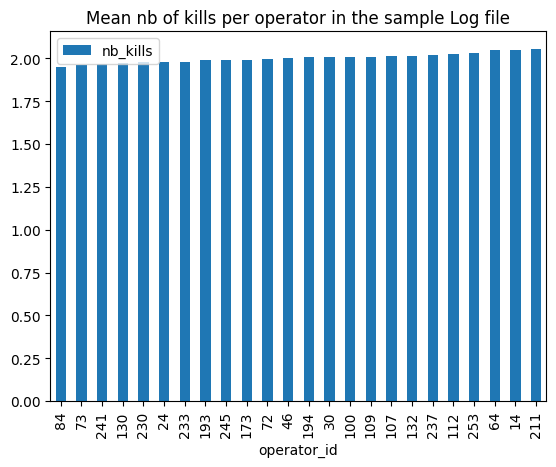

In [13]:
operators_mean_kills = df.group_by('operator_id').agg(pl.col('nb_kills').mean()).sort('nb_kills')
operators_mean_kills.to_pandas().plot(kind='bar', x='operator_id', y='nb_kills', title='Mean nb of kills per operator in the sample Log file')
plt.show()

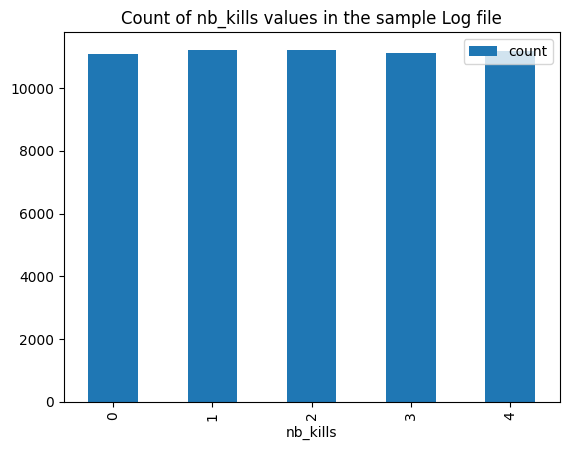

In [14]:
df['nb_kills'].value_counts().sort('nb_kills').to_pandas().plot(kind='bar', x='nb_kills', y='count', title='Count of nb_kills values in the sample Log file')
plt.show()

In [15]:
len(df['match_id'].unique())

1000

In [16]:
len(df['player_id'].unique())

100

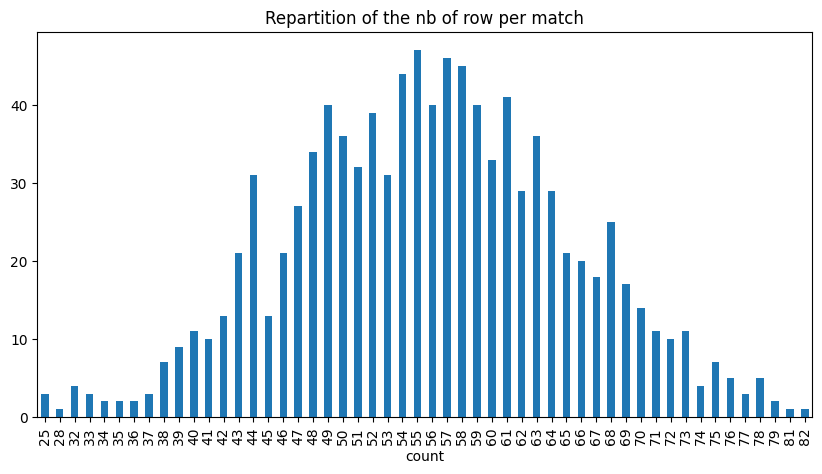

In [17]:
nb_row_per_match = df['match_id'].value_counts()
nb_row_per_match_distribution = nb_row_per_match.group_by('count').agg(pl.col('count').count().alias('nb_rows')).sort('count')

nb_row_per_match_distribution.to_pandas().plot(
    kind='bar', x='count', y='nb_rows', title='Repartition of the nb of row per match', legend=False, figsize=(10, 5)
)

plt.show() 

In [18]:
mu = nb_row_per_match['count'].mean()
std = nb_row_per_match['count'].std()

print(f'Average nb of row per match: {mu}')
print(f'Std nb of row per match: {std}')

Average nb of row per match: 55.833
Std nb of row per match: 9.332856648058687


Thanks to all these information, I can implement a match generation script.

```python3
>>> %timeit -r 5 -n 3 matchs = generate_matchs(10**4)
... 1.07 s ± 6.82 ms per loop (mean ± std. dev. of 5 runs, 3 loops each)
```

```python3
>>> %time matchs_100k = generate_matchs(10 ** 5)
... CPU times: user 10.7 s, sys: 1.61 s, total: 12.3 s
... Wall time: 12.3 s
```

In [30]:
path_10k = Path('data/logs/10k_matches.log')
if not path_10k.exists():
    matches_10k = generate_matches(10 ** 4)
    store_matches(path_10k, matches_10k)

In [2]:
path_100k = Path('data/logs/100k_matches.log')
if not path_100k.exists():
    matches_100k = generate_matches(10 ** 5, corruption_ratio=0)
    store_matches(path_100k, matches_100k)

In [ ]:
path_1M = Path('data/logs/1M_matchs.log')
if not path_1M.exists():
    generate_millions_matchs(n_million=1, path=path_1M, corruption_ratio=0)

4 min to generate 1M matchs - 4,11 Go 

In [18]:
generate_dummy_daily_results()